In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Load datasets
calls_df = pd.read_csv(r'dataset\calls.csv')
reasons_df = pd.read_csv(r'dataset\reasons.csv')

# Merge calls_df with reasons_df on 'call_id'
merged_df = pd.merge(calls_df, reasons_df, on='call_id', how='left')

# Function to normalize text (remove extra spaces, make lowercase, handle hyphenation)
def normalize_reason(reason):
    if pd.isna(reason):  # Check if the value is NaN
        return reason
    reason = reason.lower().strip()  # Convert to lowercase and strip whitespace
    reason = re.sub(r'\s+', ' ', reason)  # Replace multiple spaces with single space
    reason = re.sub(r'-', ' ', reason)  # Replace hyphens with spaces
    return reason

# Apply normalization to the primary_call_reason
merged_df['primary_call_reason'] = merged_df['primary_call_reason'].apply(normalize_reason)

# Extract call transcripts
transcripts = merged_df['call_transcript'].fillna('')

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=100, stop_words='english')

# Fit and transform the transcripts into TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(transcripts)

# Extract feature names (keywords)
keywords = tfidf.get_feature_names_out()

# Create a DataFrame for TF-IDF values
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=keywords)

# Add the extracted keywords back to the original dataframe
merged_df = pd.concat([merged_df, tfidf_df], axis=1)

# Define keyword to reason mapping
keyword_to_reason = {
    'delay': 'flight delay',
    'baggage': 'baggage issue',
    'cancel': 'flight cancellation',
    'upgrade': 'upgrade request',
    'seat': 'seating issue',
    'irrop': 'irregular operations',
    # Add more mappings as needed
}

# Function to map keywords to call reasons
def map_keywords_to_reason(transcript):
    for keyword, reason in keyword_to_reason.items():
        if keyword in transcript.lower():
            return reason
    return None

# Apply the mapping function to the transcripts
merged_df['auto_tagged_reason'] = merged_df['call_transcript'].apply(map_keywords_to_reason)

# Fill missing values in primary_call_reason with the auto-tagged reason
merged_df['primary_call_reason'] = merged_df['primary_call_reason'].fillna(merged_df['auto_tagged_reason'])

# Drop the auto_tagged_reason column after processing
merged_df = merged_df.drop(columns=['auto_tagged_reason'])

# Final check of the processed primary_call_reason
print(merged_df['primary_call_reason'].unique())


['voluntary cancel' 'booking' 'irrops' 'upgrade' 'seating' 'mileage plus'
 'checkout' 'seating issue' 'voluntary change' 'post flight' 'check in'
 'other topics' 'communications' 'schedule change' 'products & services'
 'flight delay' None 'digital support' 'flight cancellation' 'disability'
 'unaccompanied minor' 'upgrade request' 'baggage' 'traveler updates'
 'etc' 'baggage issue' 'products and services']


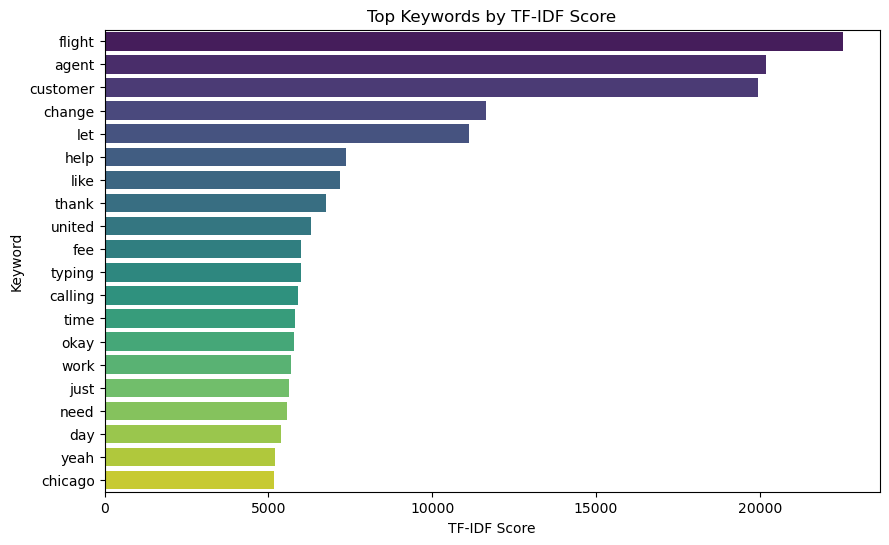

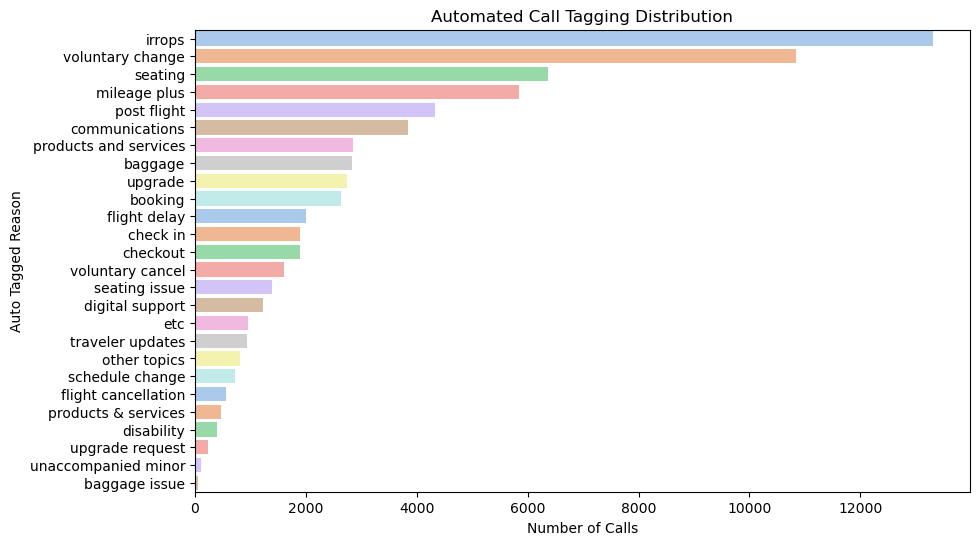

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Visualize Top Keywords by TF-IDF Score
tfidf_sum = tfidf_matrix.sum(axis=0).A1
keyword_scores = dict(zip(keywords, tfidf_sum))
keyword_df = pd.DataFrame(keyword_scores.items(), columns=['Keyword', 'TF-IDF Score']).sort_values(by='TF-IDF Score', ascending=False)

# Plotting the top keywords
plt.figure(figsize=(10, 6))
sns.barplot(data=keyword_df.head(20), x='TF-IDF Score', y='Keyword', palette='viridis')
plt.title('Top Keywords by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Keyword')
plt.show()

# Step 2: Visualize Automated Call Tagging Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, y='primary_call_reason', order=merged_df['primary_call_reason'].value_counts().index, palette='pastel')
plt.title('Automated Call Tagging Distribution')
plt.xlabel('Number of Calls')
plt.ylabel('Auto Tagged Reason')
plt.show()


In [2]:
tfidf_df

,150,able,agent,ahead,airlines,alright,appreciate,available,better,booked,...,unfortunately,united,ve,voucher,way,wednesday,week,welcome,work,yeah
0,0.000000,0.000000,0.269319,0.000000,0.091475,0.070741,0.060014,0.073385,0.198901,0.060280,...,0.000000,0.224501,0.059601,0.113116,0.000000,0.000000,0.000000,0.000000,0.109892,0.155989
1,0.000000,0.000000,0.273609,0.046880,0.034850,0.053901,0.045727,0.055916,0.000000,0.045930,...,0.058206,0.068423,0.090826,0.000000,0.110118,0.000000,0.000000,0.040998,0.125598,0.039618
2,0.066626,0.000000,0.251409,0.000000,0.028464,0.000000,0.074697,0.137010,0.000000,0.000000,...,0.000000,0.083829,0.037092,0.000000,0.044970,0.000000,0.102275,0.066972,0.136779,0.000000
3,0.167918,0.045641,0.211209,0.032168,0.023913,0.110955,0.031377,0.000000,0.034663,0.094547,...,0.079878,0.070425,0.000000,0.177419,0.037780,0.109482,0.000000,0.028131,0.086181,0.108739
4,0.172545,0.000000,0.325545,0.049581,0.036858,0.000000,0.048362,0.059137,0.106856,0.048576,...,0.000000,0.108548,0.144089,0.000000,0.058231,0.000000,0.066217,0.086720,0.221390,0.041901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71805,0.000000,0.000000,0.254578,0.000000,0.074116,0.000000,0.048625,0.000000,0.214873,0.048840,...,0.000000,0.109138,0.048291,0.183299,0.000000,0.000000,0.000000,0.043596,0.089037,0.084257
71806,0.000000,0.000000,0.292068,0.000000,0.033067,0.000000,0.000000,0.000000,0.191735,0.000000,...,0.165689,0.129848,0.129272,0.081781,0.000000,0.075698,0.000000,0.038901,0.039725,0.112777
71807,0.000000,0.132225,0.237953,0.046595,0.034638,0.053573,0.045449,0.055576,0.251051,0.000000,...,0.057852,0.034004,0.090274,0.000000,0.109449,0.000000,0.000000,0.081497,0.124834,0.039377
71808,0.000000,0.000000,0.335109,0.000000,0.042683,0.066016,0.056006,0.000000,0.061872,0.056254,...,0.000000,0.083803,0.000000,0.000000,0.000000,0.097710,0.153366,0.100426,0.000000,0.000000


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create features and labels
X = tfidf_df.values  # Using the TF-IDF features as input
y = merged_df['primary_call_reason']  # Using normalized call reasons as output

# Convert categorical labels to numerical labels
y = pd.factorize(y)[0]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model for future use (optional)
import joblib
joblib.dump(classifier, 'call_classifier_model.pkl')


Confusion Matrix:
[[ 16   3   8  31   5  19  11   9   3  24   8   5   1  12   3   0   0   6
    5   1   1   0   7   3   1   0   6]
 [  4  10  12  52  14  28  31  11   8  46  24  14   3  16   5   0   9   6
    5   0   1   2  18   4   0   0  10]
 [  7   5  24  92  13  37  35  12  13  81  30  17  10  25   5   0  13   6
    1   2   0   4  26   4   8   1  17]
 [ 34  70  94 531  90 230 221  62  42 419 162  73  25 149  23  12  61  40
   23  15   3   8  98  37  34   0 103]
 [  6  11  11  99  22  53  41  17   6  76  25  10   3  26   3   1  19  10
    7   2   0   0  33   7   4   1  29]
 [ 17  24  51 252  47 117 123  35  30 187  81  35   7  64   8  13  45  21
    8   7   0   4  54  13  18   1  51]
 [ 17  36  47 224  48 132  99  33  19 159  61  42  13  58  13   5  23  18
    8   9   1   0  45  14  19   2  45]
 [  4   9  18  73  16  41  29   6   5  49  20  11   2  24   6   3  14   4
    1   5   1   0   8   2   2   0  13]
 [  0   9  12  48  10  31  22   5   8  34  18   9   3  14   0   1   1   3
    

['call_classifier_model.pkl']

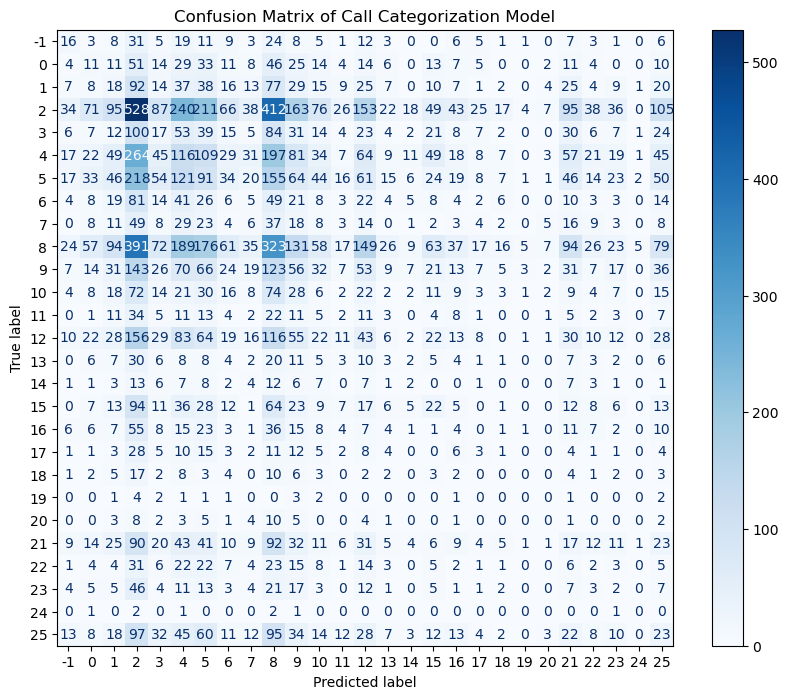

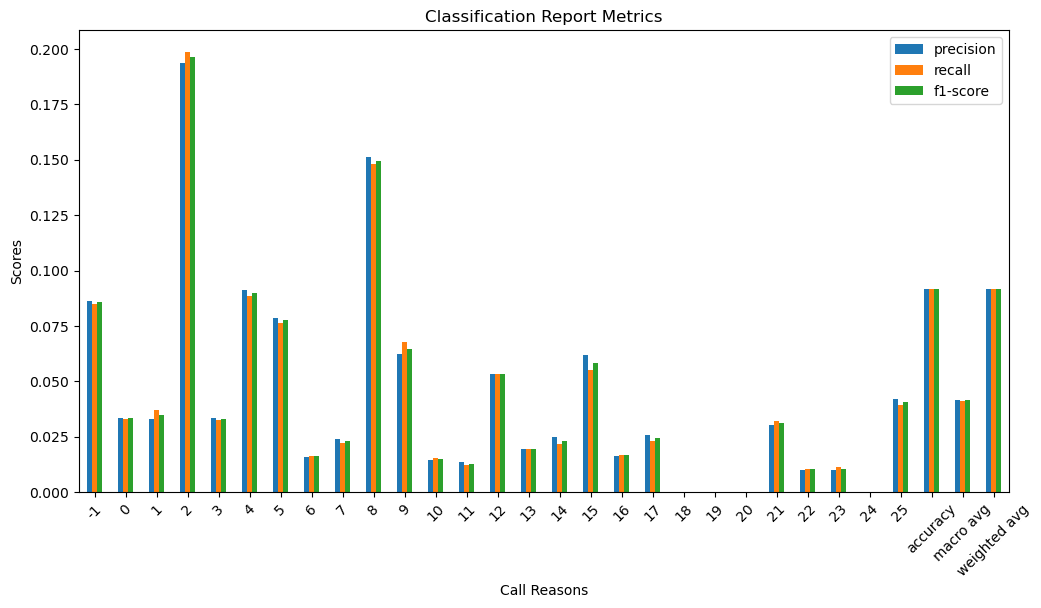

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))  # Ensure to use np.unique to get correct labels

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test)).plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix of Call Categorization Model')
plt.show()

# Step 4: Visualize Classification Report (Precision, Recall, F1-Score)
# Create a classification report
report = classification_report(y_test, y_pred, target_names=np.unique(y_test), output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plotting Precision, Recall, and F1-Score
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title('Classification Report Metrics')
plt.xlabel('Call Reasons')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()